# Российский рынок
## Бэктестинг

Здесь проведем бэкстестинг и определим оптимальный период для ребалансировки портфеля

In [7]:
import os
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from tqdm import tqdm_notebook
import seaborn as sns

%matplotlib inline
# Для отрисовки сетки за графиком
plt.rc('axes', axisbelow=True)

---

In [8]:
# Функция вычисляющая риск и доходность для конкретного портфеля
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) * num_periods_annually
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(num_periods_annually)
    return std, returns

---

Функции для оптимизации по максимальному коэффициенту Шарпа

In [9]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

In [10]:
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

---

Функции для оптимизации по минимальному риску

In [11]:
def portfolio_risk(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

In [12]:
def min_risk(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_risk, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)

    return result

---

Функции для оптимизации по максимальной доходности

In [13]:
def neg_portfolio_return(weights, mean_returns, cov_matrix):
    return -1*portfolio_performance(weights, mean_returns, cov_matrix)[1]

In [14]:
def max_return(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(neg_portfolio_return, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)

    return result

---

Функции для поиска оптимальной границы

In [15]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    
    def portfolio_return(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_risk, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [16]:
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

---

Функции для бэктестинга

In [17]:
# Оптимизация по максимальному коэф. Шарпа для части таблицы (данных)
def opt_max_sharpe_ratio(part_price, risk_free_rate):
    returns = part_price.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [18]:
# Оптимизация по заданному риску
def opt_targeted_risk(part_price, target):
    returns = part_price.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_risk(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[0]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_risk(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(neg_portfolio_return, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [1]:
# Оптимизация по заданной доходности
def opt_targeted_return(part_price, target):
    returns = part_price.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_risk, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Старт

Загружаем цены закрытия акций за предыдущий год

In [20]:
# акции из индекса Мос. Биржи
stocks = ["AFKS",
          "AFLT",
          "ALRS",
          "CBOM",
          "CHMF",
          "DSKY",
          "FEES",
          "GAZP",
          "GMKN",
          "HYDR",
          "IRAO",
          "LKOH",
          "MAGN",
          "MGNT",
          "MOEX",
          "MTLR",
          "MTSS",
          "MVID",
          "NLMK",
          "NVTK",
          "PHOR",
          "PIKK",
          "PLZL",
          "POLY",
          "RNFT",
          "ROSN",
          "RTKM",
          "RUAL",
          "SBER",
          "SBERP",
          "SNGS",
          "SNGSP",
          "TATN",
          "TATNP",
          "TRMK",
          "TRNFP",
          "UPRO",
          "UWGN",
          "VTBR",
          "YNDX"]
len(stocks)

40

Задаем интервал для загрузки данных

In [22]:
start = '2011-01-01'
stop  = '2018-11-01'

In [23]:
price = pd.DataFrame()

# Временная, т.к. для первого добавления данных должны быть все индексы
price['SBER'] = pd.read_csv('./csv/'+'SBER'+'.csv', parse_dates=['Date'], index_col=0)['Close'][start:stop]

for symbol in stocks:
    price[symbol] = pd.read_csv('./csv/'+symbol+'.csv', parse_dates=['Date'], index_col=0)['Close'][start:stop]
#price.head()
price.shape

(1970, 40)

In [24]:
# How NaN rows
price.isnull().sum().sum()

8707

Удаляем из таблицы акции у которых пропусков (NaN) больше 50

In [25]:
# isnull = price.isnull().sum()
# for ticker in stocks:     #if too many null entries for given stock, exclude from analysis
#     try:
#         if isnull[ticker] > 50:
#             price.drop(ticker, axis=1, inplace=True)
#     except:
#         pass

In [26]:
# Смотрим, сколько акций осталось
price.columns.size

40

Заполняем пустые ячейки ценой предыдущего дня. Если ее нет, то последующего

In [27]:
# How NaN rows
price.isnull().sum().sum()

8707

In [28]:
price.fillna(method='ffill', inplace=True)
price.fillna(method='bfill', inplace=True)

In [29]:
# How NaN rows
price.isnull().sum().sum()

0

Загружаем индекс Московской Биржи (IMOEX)

In [30]:
imoex = pd.read_csv('./csv/'+'IMOEX.csv', parse_dates=['Date'], index_col=0)['Close'][start:stop]
#imoex.plot();

### Задаем параметры для бэктестинга

In [31]:
# Через сколько дней переоптимизируем портфель
shift = 60

# Rolling window (days)
rolling = 250

# Безрисковая процентная ставка
risk_free_rate = 0.00

# Заданный риск портфеля для оптимизации
TargetRisk = 0.17

# Заданная доходность портфеля для оптимизации
TargetReturn = 0.20

num_periods_annually = 252 # Количество операционных дней в году

Запускаем бэктестинг. Расчитываем доходность портфеля каждый день, но ребалансировку делаем через каждые **shift** дней

In [32]:
index = price.index
p_returns = pd.DataFrame(columns=['p_returns'])
distribution = pd.DataFrame(index=price.columns)
portfolio_alloc = 0
#sharpe_ratio = pd.DataFrame(columns=['sharpe_ratio'])

# Расчитываем доходность портфеля каждый день, но ребалансировку делаем через каждые shift дней
s = 0
d0 = ''
d1 = ''
last = 0
for day in tqdm_notebook(range(rolling-1, price.index.size-1)):
    # каждые shift дней заново оптимизируем портфель
    if s == 0:
        #print('Оптимизируем. day = ', day)
        d0 = index[day-rolling+1]
        d1 = index[day]
#         print('d0 = ', d0, 'd1 = ', d1)
        p = price.loc[d0:d1]
        opt_res = opt_max_sharpe_ratio(p, risk_free_rate)
        #opt_res = opt_targeted_risk(p, TargetRisk)
        #opt_res = opt_targeted_return(p, TargetReturn)
        if(opt_res['success']==True):
            portfolio_alloc = np.array(opt_res['x'])
            distribution[index[day].strftime('%Y-%m-%d')] = portfolio_alloc
            #distribution[index[day]] = portfolio_alloc
            #sharpe_ratio.loc[index[day]] = -1*opt_res['fun']
        else:
            print('ERROR: ', opt_res['message'])
    
    # Вычисление доходности портфеля
    date0 = d1
    date1 = index[day+1]
#     if (s==0):
#         print('date0 = ', date0, 'date1 = ', date1)
    a_return = (price.loc[date1] - price.loc[date0])/price.loc[date0]
    if (p_returns.size!=0 and s==0):
        last = p_returns.iloc[-1].values
        #last = 0
    p_returns.loc[index[day+1]] = np.sum(a_return*portfolio_alloc) + last
    
    # Ведем отсчет дней до новой оптимизации портфеля
    s = s + 1
    if s == shift:
        s = 0
        #print(day)

Считаем Максимальную доходность по Шарпу для данных начиная с rolling-1

In [33]:
p = price.iloc[rolling-1:]
sharpe_max = opt_max_sharpe_ratio(p, risk_free_rate)
portfolio_alloc = sharpe_max['x']

index = p.index
sharpe_max_returns = pd.DataFrame(columns=['returns'])
for day in range(1, p.index.size):
    # Вычисляем доходность портфеля
    date0 = index[0]
    date1 = index[day]
    a_return = (p.loc[date1] - p.loc[date0])/p.loc[date0]
    sharpe_max_returns.loc[index[day]] = np.sum(a_return*portfolio_alloc)

In [34]:
# Выводит список акций и их доли в портфеле
portfolio_alloc = []
shares = price.columns[np.where(sharpe_max['x']>0.001)]
weight = sharpe_max['x'][sharpe_max['x']>0.001]

for i in range(len(shares)):
    print(shares[i], '\t', round(weight[i]*100,1))
    portfolio_alloc.append(weight[i])

ALRS 	 6.8
CBOM 	 28.7
DSKY 	 2.8
MAGN 	 2.4
MVID 	 1.4
PIKK 	 16.7
PLZL 	 8.3
POLY 	 4.4
TATN 	 0.3
TATNP 	 19.3
TRNFP 	 7.6
YNDX 	 1.2


Строим итоговый график



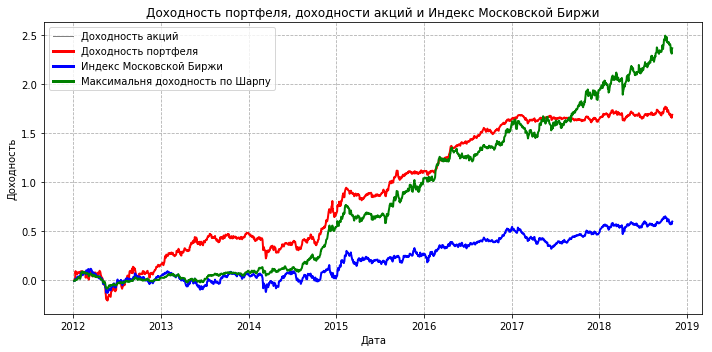

In [35]:
plt.figure(figsize=(10,5))

gray_line = mlines.Line2D([], [], color='gray', linewidth=1, label='Доходность акций')
#plt.plot(price.iloc[rolling-1:].pct_change().cumsum(),'gray', linewidth=1, alpha=0.5)

red_line = mlines.Line2D([], [], color='red', linewidth=3, label='Доходность портфеля')
plt.plot(p_returns, 'red', linewidth=2)

blue_line = mlines.Line2D([], [], color='blue', linewidth=3, label='Индекс Московской Биржи')
plt.plot(imoex[price.iloc[rolling-1:].index[0]:].pct_change().cumsum(), 'blue', linewidth=2)

green_line = mlines.Line2D([], [], color='green', linewidth=3, label='Максимальня доходность по Шарпу')
plt.plot(sharpe_max_returns, 'green', linewidth=2)


plt.grid(True, linestyle='--')
plt.title('Доходность портфеля, доходности акций и Индекс Московской Биржи')
plt.xlabel('Дата')
plt.ylabel('Доходность')
plt.legend(handles=[gray_line, red_line, blue_line, green_line])
plt.tight_layout();

## Подбор параметров

In [78]:
# Через сколько дней переоптимизируем портфель
shift = 60

# Rolling window (days)
rolling = 250

# Безрисковая процентная ставка
risk_free_rate = 0.00

# Заданный риск портфеля для оптимизации
TargetRisk = 0.17

# Заданная доходность портфеля для оптимизации
TargetReturn = 0.20

num_periods_annually = 252 # Количество операционных дней в году

Запускаем бэктестинг. Расчитываем доходность портфеля каждый день, но ребалансировку делаем через каждые **shift** дней

In [89]:
ret_rolling = []
for rolling in tqdm_notebook(range(100, 250, 50), desc='rolling'):
    ret_shift = []
    for shift in tqdm_notebook(range(5, 250, 50), desc='shift', leave=False):
        # Расчитываем доходность портфеля каждый день, но ребалансировку делаем через каждые shift дней
        s = 0
        d0 = ''
        d1 = ''
        last = 0
        index = price.index
        p_returns = pd.DataFrame(columns=['p_returns'])
        distribution = pd.DataFrame(index=price.columns)
        portfolio_alloc = 0
        for day in tqdm_notebook(range(rolling-1, price.index.size-1), desc='day', leave=False):
            # каждые shift дней заново оптимизируем портфель
            if s == 0:
                d0 = index[day-rolling+1]
                d1 = index[day]
                p = price.loc[d0:d1]
                opt_res = opt_max_sharpe_ratio(p, risk_free_rate)
                if(opt_res['success']==True):
                    portfolio_alloc = np.array(opt_res['x'])
                    distribution[index[day].strftime('%Y-%m-%d')] = portfolio_alloc
                else:
                    #print('ERROR: ', opt_res['message'])
                    pass

            # доходность портфеля
            date0 = d1
            date1 = index[day+1]
            a_return = (price.loc[date1] - price.loc[date0])/price.loc[date0]
            if (p_returns.size!=0 and s==0):
                last = p_returns.iloc[-1].values
            p_returns.loc[index[day+1]] = np.sum(a_return*portfolio_alloc) + last

            # Ведем отсчет дней до новой оптимизации портфеля
            s = s + 1
            if s == shift:
                s = 0
        ret_shift.append(p_returns.iloc[-1].values[0])
    ret_rolling.append(ret_shift)

In [137]:
ret_rolling = []
for rolling in tqdm_notebook(range(10, 250, 10), desc='rolling'):
    ret_shift = []
    for shift in range(5, 250, 5):
        d0 = ''
        d1 = ''
        last = 0
        index = price.index
        p_returns = pd.DataFrame(columns=['p_returns'])
        distribution = pd.DataFrame(index=price.columns)
        portfolio_alloc = 0
        for day in range(rolling-1, price.index.size, shift):
            # каждые shift дней заново оптимизируем портфель
            # 99-100+1=0
            d0 = index[day-rolling+1]
            # 99
            d1 = index[day]
            p = price.loc[d0:d1]
            opt_res = opt_max_sharpe_ratio(p, risk_free_rate)
            if(opt_res['success']==True):
                portfolio_alloc = np.array(opt_res['x'])
                distribution[index[day].strftime('%Y-%m-%d')] = portfolio_alloc
            else:
                #print('ERROR: ', opt_res['message'])
                pass

            # Calculating portfolio return
            # 99
            date0 = d1
            # 99+5=104
            if (day+shift > price.index.size):
                date1 = index[-1]
            else:
                date1 = index[day+shift]
            a_return = (price.loc[date1] - price.loc[date0])/price.loc[date0]
            if (p_returns.size!=0):
                last = p_returns.iloc[-1].values
            p_returns.loc[date1] = np.sum(a_return*portfolio_alloc) + last
            
            
        ret_shift.append(p_returns.iloc[-1].values[0])
        #print('shift = ', shift, 'day = ', day, ' sum = ', day+shift)
        #sys.stdout.flush()
    ret_rolling.append(ret_shift)
    

### Строим 3D график эффективных границ

In [ ]:
import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode

#для вывода plotly-графиков в ноутбуке
init_notebook_mode(connected=False)

In [138]:
x = [i for i in range(10, 250, 10)]
y = [i for i in range(5, 250, 5)]
z = np.array(ret_rolling)

In [139]:
data = [
    go.Surface(
        x=x,
        y=y,
        z=z
    )
]

In [140]:
layout = go.Layout(
    title='Эффективные границы',
    width=800,
    height=700,
    scene=dict(
        xaxis=dict(
            title='shift',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title='rolling',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(title='Доходность',
                   gridcolor='rgb(255, 255, 255)',
                   zerolinecolor='rgb(255, 255, 255)',
                   showbackground=True,
                   backgroundcolor='rgb(230, 230,230)'
                  )
    )
)

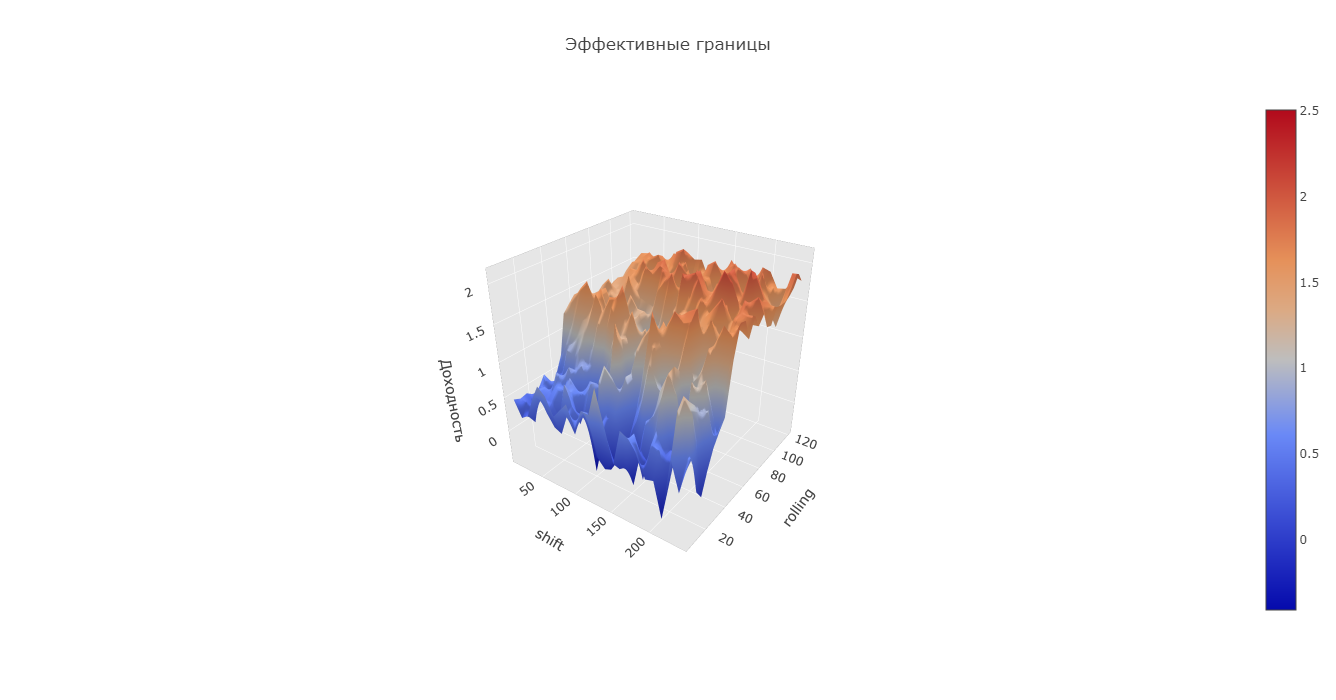

In [141]:
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

Из анализа графика видно, что максимальной доходности оптимальные значения для **rolling** должны быть более 80 дней